In [52]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from __future__ import division
import os
import cPickle as pickle
import pandas as pd
import loadmat
import numpy as np
from scipy import stats
import scipy as sp
import fdr_correct

In [4]:
SJdir = '/home/knight/matar/MATLAB/DATA/Avgusta/'

In [461]:
#MY DATA
filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv')
df = pd.read_csv(filename)
bl_st = -500

starts, ends, eleclist, subjlist, tasklist, min_p, max_p, dur = [[] for i in range(8)]
for p in ['D', 'S','R','SR']:

    for i in df.groupby(['subj','task']):
        subj, task = i[0]

        if subj not in ['ST27','ST32','CP9','CP7']:
            continue
            
        savedir = os.path.join(SJdir, 'PCA', 'compare_conditions', 'mydata')

        filename = os.path.join(SJdir, 'Subjs', subj, task, 'HG_elecMTX_zscore.mat')
        data_dict = loadmat.loadmat(filename)
        data = data_dict['data_zscore']
        active_elecs = data_dict['active_elecs']
        RTs = data_dict['RTs']

        filename = os.path.join(SJdir,'Subjs', subj, task, 'levels.mat')
        data_dict = loadmat.loadmat(filename)
        levels = data_dict['levels']

        elecs = list(i[1][i[1].pattern == p].elec)
        if len(elecs)==0: #the pattern doesn't exist
            continue

        eidx = np.in1d(active_elecs, elecs)

        for k in np.where(eidx)[0]:

            elec = active_elecs[k]
            datastack_1 = np.vstack(data[k,:,:][((levels == 0) | (levels == 20)),:])
            datastack_2 = np.vstack(data[k,:,:][((levels == 80) | (levels == 10)),:])

            #calculate significance
            pvals = list()
            for j in np.arange(0, datastack_2.shape[1]):
                (t, pval) = stats.ttest_ind(datastack_2[:,j], datastack_1[:,j])
                pvals.append(pval)
            
            #thr = fdr_correct.fdr2(pvals, q = 0.05)
            thr = numpy.float64(0.05) #no fdr correction, just take p<0.05
            H = np.array(np.array(pvals<thr)).astype('int')

            if (thr>0):
                #find elecs with window 
                difference = np.diff(H, n = 1, axis = 0)
                start_idx = np.where(difference==1)[0]+1
                end_idx = np.where(difference == -1)[0]

                if start_idx.size > end_idx.size: #last chunk goes until end
                    end_idx = np.append(end_idx, int(datastack_1.shape[1]))
                    
                elif start_idx.size < end_idx.size:
                    start_idx = np.append(0, start_idx) #starts immediately significant

                if (start_idx.size!=0):
                    if (start_idx[0] > end_idx[0]): #starts immediately significant
                        start_idx = np.append(0, start_idx)

                if (start_idx.size!=0):
                    if (end_idx[-1] < start_idx[-1]):#significant until end
                        end_idx = np.append(end_idx, int(datastack_1.shape[1]))
                start_idx = start_idx + bl_st
                end_idx = end_idx + bl_st
            else:
                start_idx = np.zeros((1,))
                end_idx = np.zeros((1,))

            #store
            eleclist.extend([elec]*len(end_idx))
            subjlist.extend([subj]*len(end_idx))
            tasklist.extend([task]*len(end_idx))            
            starts.extend(start_idx)
            ends.extend(end_idx)
            dur.extend(end_idx - start_idx)
            
            start_idx = start_idx-bl_st #shift to access data
            end_idx = end_idx-bl_st
            min_p.extend([min(pvals[start_idx[i]:end_idx[i]]) for i in range(len(end_idx))])
            max_p.extend([max(pvals[start_idx[i]:end_idx[i]]) for i in range(len(end_idx))])
            
            start_idx = start_idx+bl_st #shift back for plotting
            end_idx = end_idx+bl_st
            
#             #plot
#             f, ax = plt.subplots(figsize = (10, 5))
#             ax.axhline(y = 0, color = 'k', lw = 1)
#             ax.axvline(x = 0, color = 'k', lw = 1)    

#             ax.plot(np.arange(-500, datastack_2.shape[1]-500), datastack_2.mean(axis = 0), color = 'green', lw = 3, label = '80/100\n%i trials' %(datastack_2.shape[0]), zorder = 10)
#             sem = np.std(datastack_2, axis = 0)/np.sqrt(datastack_2.shape[0]-1)
#             ax.fill_between(np.arange(-500, datastack_2.shape[1]-500), datastack_2.mean(axis = 0)+sem, datastack_2.mean(axis=0)-sem, zorder = 10, edgecolor = 'k', facecolor = 'green', alpha = 0.5)

#             ax.plot(np.arange(-500, datastack_1.shape[1]-500), datastack_1.mean(axis = 0), color = 'purple', lw = 2, label = '0/20\n%i trials' %(datastack_1.shape[0]), zorder = 8)
#             sem = np.std(datastack_1, axis = 0)/np.sqrt(datastack_1.shape[0]-1)
#             ax.fill_between(np.arange(-500, datastack_1.shape[1]-500), datastack_1.mean(axis = 0)+sem, datastack_1.mean(axis=0)-sem, alpha = 0.5, zorder = 8, edgecolor = 'k', facecolor = 'purple')

#             ax.axvline(x = RTs.mean(), color = 'g', lw = 2, ls = ':', label = 'Mean RT')# - %ims' %(RTs.mean()))

#             if start_idx.size>0:
#                 for i, s in enumerate(start_idx):
#                     tmp = np.arange(s, end_idx[i])
#                     start = s
#                     finish = end_idx[i]
#                     ax.plot(tmp, np.zeros(tmp.size), color = 'black', linewidth = 4)#, label = (start, finish))
#                 ax.plot(tmp, np.zeros(tmp.size), color = 'black', linewidth = 4, label = 'p<0.05\nnot FDR corrected')

#             ax.autoscale(tight = True)
#             ax.spines['top'].set_visible(False)
#             ax.spines['right'].set_visible(False)
#             ax.get_xaxis().tick_bottom()
#             ax.get_yaxis().tick_left()
#             ax.set_ylabel('HG (zscore)', fontsize = 14, weight = 'bold')
#             ax.set_xlabel('Time (ms)', fontsize = 14, weight = 'bold')
#             ax.xaxis.set_tick_params(labelsize = 14)
#             ax.yaxis.set_tick_params(labelsize = 14)
#             #ax.set_ylim([-0.25, 2.4])
#             ax.set_xlim([-500, 3500])
#             ax.set_title('%s %s %s e%i' %(subj, task, p, elec))

#             #ax[0].annotate('RT', xy = (RTs.mean()+30, 2), color = 'green', fontsize = 14, fontweight = 'bold')

#             handles, labels = ax.get_legend_handles_labels()
#             lgnd = ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05,1), fontsize = 14, frameon = False)    

#             filename = os.path.join(savedir, 'noFDR', '%s_%s_%s_%i_noFDR.png' %(subj, task, p, elec))
#             f.savefig(filename, bbox_inches='tight')
#             plt.close()


In [462]:
dfall = pd.DataFrame([subjlist, tasklist, eleclist, starts, ends, dur, min_p, max_p])

dfall = dfall.transpose()
dfall.columns = ['subj','task','elec','start_idx','end_idx', 'dur', 'min_p', 'max_p']

dfall.to_csv(os.path.join(savedir, 'noFDR', 'sig_windows.csv'))

In [463]:
dfall.head()

,subj,task,elec,start_idx,end_idx,dur,min_p,max_p
0,CP7,DecisionAud,21,-267,-239,28,0.02676073,0.04853286
1,CP7,DecisionAud,21,1120,1186,66,3.627706e-05,0.04119271
2,CP7,DecisionAud,21,2492,2506,14,0.04195241,0.04935286
3,CP7,DecisionAud,21,3110,3175,65,0.005380342,0.0498841
4,CP7,DecisionAud,21,3466,3482,16,0.0369048,0.04928434


In [98]:
filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL','sig_windows_Matar.csv')
df = pd.read_csv(filename)
df = df[['subj','task','elec','start_idx','end_idx']]

filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv')
df2 = pd.read_csv(filename)

df = df.merge(df2[['subj','task','elec', 'pattern']], how = 'inner')

#print sum((df.pattern == 'S') | (df.pattern == 'SR'))/df.shape[0]

print df[df.pattern == 'D'].shape[0]/df2[( df2.pattern == 'D') &((df2.task == "DecisionAud") | (df2.task == "DecisionVis"))].shape[0]
df[['subj','elec','pattern']]

0.0833333333333


,subj,elec,pattern
0,CP7,12,S
1,CP9,11,SR
2,CP9,16,SR
3,CP9,28,SR
4,ST27,14,D
5,ST27,33,SR
6,ST27,35,SR
7,ST27,36,SR
8,ST27,41,SR
9,ST27,102,D


In [140]:
df = pd.read_csv(os.path.join(SJdir, 'PCA','compare_conditions','EmoGen', 'noFDR', 'sig_windows.csv'))

filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv')
df2 = pd.read_csv(filename)

df = df.merge(df2[['subj','task','elec', 'pattern']], how = 'inner')
print sum((df.pattern == 'S') | (df.pattern == 'SR'))/df.shape[0]

df = df[(df.dur>100) & (df.max_p<0.05)].drop_duplicates('elec')

print df[df.pattern == 'D'].shape[0]/df2[(df2.pattern == 'D') & (df2.task == "EmoGen")].shape[0]



print 5/(df2[df2.subj.isin(['JH2','GP15','GP35'])][(df2.task == 'EmoGen') & (df2.pattern == 'D')].shape[0]-3)

df[['subj','task', 'elec','pattern']]
#drop GP15 67, 66, 5 and 7; JH2 2

0.199697428139
0.181818181818
0.104166666667


,subj,task,elec,pattern
19,GP15,EmoGen,10,D
90,GP15,EmoGen,52,D
108,GP15,EmoGen,66,D
120,GP15,EmoGen,67,D
131,GP35,EmoGen,4,D
140,GP35,EmoGen,5,D
149,GP35,EmoGen,7,D
227,GP35,EmoGen,45,D
264,JH2,EmoGen,2,D
303,JH2,EmoGen,13,D


In [309]:

bl_st = -500

for i in df.groupby(['subj','task']):
    subj, task = i[0]

    savedir = os.path.join(SJdir, 'PCA', 'compare_conditions', 'mydata', 'meanvals')
    
    filename = os.path.join(SJdir, 'Subjs', subj, task, 'HG_elecMTX_zscore.mat')
    data_dict = loadmat.loadmat(filename)
    data = data_dict['data_zscore']
    active_elecs = data_dict['active_elecs']
    RTs = data_dict['RTs']

    filename = os.path.join(SJdir,'Subjs', subj, task, 'levels.mat')
    data_dict = loadmat.loadmat(filename)
    levels = data_dict['levels']

    elecs = i[1].elec
    eidx = np.in1d(active_elecs, elecs)

    df_stack = pd.DataFrame(index = levels)
    
    for k in np.where(eidx)[0]:
        
        elec = active_elecs[k]
        #datastack_1 = np.vstack(data[k,:,:][((levels == 0) | (levels == 20)),:])
        #datastack_2 = np.vstack(data[k,:,:][((levels == 80) | (levels == 10)),:])
        
        datastack = np.vstack(data[k,:,:])
        
        #find activity window
        start_idx = i[1][i[1].elec == elec].start_idx
        end_idx = i[1][i[1].elec == elec].end_idx
        
        #datastack_1 = pd.DataFrame(datastack_1[:, (start_idx - bl_st) : (end_idx - bl_st)].mean(axis = 1), index =levels[((levels == 0) | (levels == 20))])
        #datastack_2 = pd.DataFrame(datastack_2[:, (start_idx - bl_st) : (end_idx - bl_st)].mean(axis = 1), index =levels[((levels == 80) | (levels == 10))])
        
        tmp = pd.DataFrame(datastack[:, (start_idx-bl_st):(end_idx-bl_st)].mean(axis = 1), index = levels, columns = [elec])
        df_stack[elec] = tmp
        
    df_stack.to_csv(os.path.join(savedir, '%s_%s_sigwindow_meanvals.csv' %(subj, task)))
        


In [79]:
#calculate how many of my data show category effect
filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv')
df = pd.read_csv(filename)
df_stats = pd.read_csv(os.path.join(SJdir, 'PCA', 'compare_conditions', 'mydata','category_effect_mysubjs.csv'))

In [80]:
df_stats.shape

(12, 5)

In [368]:
print df.query("subj == 'ST27' and elec == 14").ROI.values
print df.query("subj == 'ST27' and elec == 102").ROI.values
print df.query("subj == 'ST32' and elec == 2").ROI.values
print '\n'
print df.query("subj == 'GP15' and task == 'EmoGen' and elec == 10").ROI.values
print df.query("subj == 'GP15' and task == 'EmoGen' and elec == 52").ROI.values
print df.query("subj == 'GP35' and task == 'EmoGen' and elec == 4").ROI.values
print df.query("subj == 'GP35' and task == 'EmoGen' and elec == 45").ROI.values
print df.query("subj == 'JH2' and task == 'EmoGen' and elec == 13").ROI.values


['MFG_premot']
['MFG']
['ITG']


['MFG']
['STG']
['Broca']
['Pre_centrl']
['Pre_centrl']


In [261]:
#EMOGEN ADJ/NOUN
filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv')
df = pd.read_csv(filename)
bl_st = -500

starts, ends, eleclist, subjlist, tasklist, min_p, max_p, dur = [[] for i in range(8)]
for p in ['D', 'S','R','SR']:

    for i in df.groupby(['subj','task']):
        subj, task = i[0]

        if subj not in ['JH2','GP35','GP15']:
            continue
        if task not in ['EmoGen']:
            continue
            
        savedir = os.path.join(SJdir, 'PCA', 'compare_conditions', task)

        filename = os.path.join(SJdir, 'Subjs', subj, task, 'HG_elecMTX_zscore.mat')
        data_dict = loadmat.loadmat(filename)
        data = data_dict['data_zscore']
        active_elecs = data_dict['active_elecs']
        RTs = data_dict['RTs']

        filename = os.path.join(SJdir,'Subjs', subj, task, 'tagged_onsets.mat')
        data_dict = loadmat.loadmat(filename)
        dfonsets = pd.DataFrame(data_dict['tagged_onsets'], columns = ['times','type'])
        tags = dfonsets['type'].values
        levels = np.unique(tags)

        elecs = list(i[1][i[1].pattern == p].elec)
        if len(elecs)==0: #the pattern doesn't exist
            continue

        eidx = np.in1d(active_elecs, elecs)

        for k in np.where(eidx)[0]:

            elec = active_elecs[k]
            datastack_1 = np.vstack(data[k,:,:][((tags == levels[0])),:])
            datastack_2 = np.vstack(data[k,:,:][((tags == levels[1])),:])

            #calculate significance
            pvals = list()
            for j in np.arange(0, datastack_2.shape[1]):
                (t, pval) = stats.ttest_ind(datastack_2[:,j], datastack_1[:,j])
                pvals.append(pval)
            
            #thr = fdr_correct.fdr2(pvals, q = 0.05)
            thr = numpy.float64(0.05) #no fdr correction, just take p<0.05
            H = np.array(np.array(pvals<thr)).astype('int')

            if (thr>0):
                #find elecs with window 
                difference = np.diff(H, n = 1, axis = 0)
                start_idx = np.where(difference==1)[0]+1
                end_idx = np.where(difference == -1)[0]

                if start_idx.size > end_idx.size: #last chunk goes until end
                    end_idx = np.append(end_idx, int(datastack_1.shape[1]))
                    
                elif start_idx.size < end_idx.size:
                    start_idx = np.append(0, start_idx) #starts immediately significant

                if (start_idx.size!=0):
                    if (start_idx[0] > end_idx[0]): #starts immediately significant
                        start_idx = np.append(0, start_idx)

                if (start_idx.size!=0):
                    if (end_idx[-1] < start_idx[-1]):#significant until end
                        end_idx = np.append(end_idx, int(datastack_1.shape[1]))
                start_idx = start_idx + bl_st
                end_idx = end_idx + bl_st
            else:
                start_idx = np.zeros((1,))
                end_idx = np.zeros((1,))

            #store
            eleclist.extend([elec]*len(end_idx))
            subjlist.extend([subj]*len(end_idx))
            tasklist.extend([task]*len(end_idx))            
            starts.extend(start_idx)
            ends.extend(end_idx)
            dur.extend(end_idx - start_idx)
            
            start_idx = start_idx-bl_st #shift to access data
            end_idx = end_idx-bl_st
            min_p.extend([min(pvals[start_idx[i]:end_idx[i]]) for i in range(len(end_idx))])
            max_p.extend([max(pvals[start_idx[i]:end_idx[i]]) for i in range(len(end_idx))])
            
            #calculate mean values per trial
            mean1, mean2 = [[] for i in range(2)]
            for st, en in zip(start_idx, end_idx):
            mean1.extend(datastack_1[:,st:en].mean(axis = 1))
            mean2.extend(datastack_2[:, st:en].mean(axis = 1))
            
            start_idx = start_idx+bl_st #shift back for plotting
            end_idx = end_idx+bl_st
            
#             #plot
#             f, ax = plt.subplots(figsize = (10, 5))
#             ax.axhline(y = 0, color = 'k', lw = 1)
#             ax.axvline(x = 0, color = 'k', lw = 1)    

#             ax.plot(np.arange(-500, datastack_2.shape[1]-500), datastack_2.mean(axis = 0), color = 'green', lw = 3, label = '2\n%i trials' %(datastack_2.shape[0]), zorder = 10)
#             sem = np.std(datastack_2, axis = 0)/np.sqrt(datastack_2.shape[0]-1)
#             ax.fill_between(np.arange(-500, datastack_2.shape[1]-500), datastack_2.mean(axis = 0)+sem, datastack_2.mean(axis=0)-sem, zorder = 10, edgecolor = 'k', facecolor = 'green', alpha = 0.5)

#             ax.plot(np.arange(-500, datastack_1.shape[1]-500), datastack_1.mean(axis = 0), color = 'purple', lw = 2, label = '1\n%i trials' %(datastack_1.shape[0]), zorder = 8)
#             sem = np.std(datastack_1, axis = 0)/np.sqrt(datastack_1.shape[0]-1)
#             ax.fill_between(np.arange(-500, datastack_1.shape[1]-500), datastack_1.mean(axis = 0)+sem, datastack_1.mean(axis=0)-sem, alpha = 0.5, zorder = 8, edgecolor = 'k', facecolor = 'purple')

#             ax.axvline(x = RTs.mean(), color = 'g', lw = 2, ls = ':', label = 'Mean RT')# - %ims' %(RTs.mean()))

#             if start_idx.size>0:
#                 for i, s in enumerate(start_idx):
#                     tmp = np.arange(s, end_idx[i])
#                     start = s
#                     finish = end_idx[i]
#                     ax.plot(tmp, np.zeros(tmp.size), color = 'black', linewidth = 4)#, label = (start, finish))
#                 ax.plot(tmp, np.zeros(tmp.size), color = 'black', linewidth = 4, label = 'p<0.05\nnot FDR corrected')

#             ax.autoscale(tight = True)
#             ax.spines['top'].set_visible(False)
#             ax.spines['right'].set_visible(False)
#             ax.get_xaxis().tick_bottom()
#             ax.get_yaxis().tick_left()
#             ax.set_ylabel('HG (zscore)', fontsize = 14, weight = 'bold')
#             ax.set_xlabel('Time (ms)', fontsize = 14, weight = 'bold')
#             ax.xaxis.set_tick_params(labelsize = 14)
#             ax.yaxis.set_tick_params(labelsize = 14)
#             #ax.set_ylim([-0.25, 2.4])
#             ax.set_xlim([-500, 3500])
#             ax.set_title('%s %s %s e%i' %(subj, task, p, elec))

#             #ax[0].annotate('RT', xy = (RTs.mean()+30, 2), color = 'green', fontsize = 14, fontweight = 'bold')

#             handles, labels = ax.get_legend_handles_labels()
#             lgnd = ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05,1), fontsize = 14, frameon = False)    

#             filename = os.path.join(savedir, 'noFDR', '%s_%s_%s_%i_NvsJJ_noFDR.png' %(subj, task, p, elec))
#             f.savefig(filename, bbox_inches='tight')
#             plt.close()


KeyboardInterrupt: 

In [5]:
params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}

plt.rcParams.update(params)

((69, 4799), (78, 4799))
128
((91, 3016), (90, 3016))
299


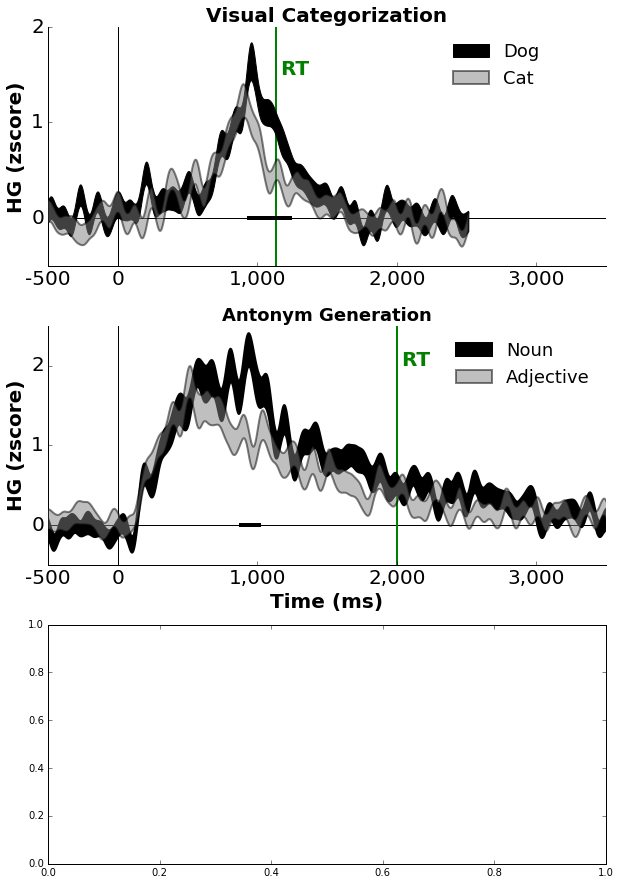

In [39]:
## PLOT FIGURES (GP15 e52 and ST32 e2)
f, ax = plt.subplots(3,1, figsize = (10,15))
f.subplots_adjust(hspace = 0.25)

subj, task, elec = ['GP15', 'EmoGen', 52]
dfstats = pd.read_csv(os.path.join(SJdir, 'PCA','compare_conditions','EmoGen', 'noFDR', 'sig_windows.csv'))
dftimes = dfstats[(dfstats.subj == subj)& (dfstats.elec == elec)][['start_idx','end_idx']]
start_idx = dftimes.start_idx.values
end_idx = dftimes.end_idx.values

filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv')
df = pd.read_csv(filename)
bl_st = -500

#get data
filename = os.path.join(SJdir, 'Subjs', subj, task, 'HG_elecMTX_zscore.mat')
data_dict = loadmat.loadmat(filename)
data = data_dict['data_zscore']
active_elecs = data_dict['active_elecs']
RTs = data_dict['RTs']

filename = os.path.join(SJdir,'Subjs', subj, task, 'tagged_onsets.mat')
data_dict = loadmat.loadmat(filename)
dfonsets = pd.DataFrame(data_dict['tagged_onsets'], columns = ['times','type'])
tags = dfonsets['type'].values
levels = np.unique(tags)

eidx = np.in1d(active_elecs, elec)
k = np.where(eidx)[0]

datastack_1 = data[eidx,:,:].squeeze()[((tags == levels[0])),:]
datastack_2 = data[eidx,:,:].squeeze()[((tags == levels[1])),:]
print(datastack_1.shape, datastack_2.shape)

#plot
ax[1].axhline(y = 0, color = 'k', lw = 1)
ax[1].axvline(x = 0, color = 'k', lw = 1)    

c1, l1, c2, l2 = ('gray', 'Adjective', 'black', 'Noun')

#ax[1].plot(np.arange(-500, datastack_1.shape[1]-500), datastack_1.mean(axis = 0), color = 'k', lw = 2, label = l2, zorder = 8)
sem = np.std(datastack_1, axis = 0)/np.sqrt(datastack_1.shape[0]-1)
ax[1].fill_between(np.arange(-500, datastack_1.shape[1]-500), datastack_1.mean(axis = 0)+sem, datastack_1.mean(axis=0)-sem, zorder = 9, edgecolor = 'k', facecolor = c2, label = l2, lw = 2)

#ax[1].plot(np.arange(-500, datastack_2.shape[1]-500), datastack_2.mean(axis = 0), color = 'k', lw = 3, label = l1, zorder = 10, ls = ':')
sem = np.std(datastack_2, axis = 0)/np.sqrt(datastack_2.shape[0]-1)
ax[1].fill_between(np.arange(-500, datastack_2.shape[1]-500), datastack_2.mean(axis = 0)+sem, datastack_2.mean(axis=0)-sem, zorder = 11, edgecolor = 'k', facecolor = c1, alpha = 0.5, label = l1, lw = 2)

ax[1].axvline(x = RTs.mean(), color = 'k', lw = 2, c ='g')#, ls = ':')#, label = 'Mean RT')# - %ims' %(RTs.mean()))

if start_idx.size>0:
    for i, s in enumerate(start_idx):
        tmp = np.arange(s, end_idx[i])
        start = s
        finish = end_idx[i]
        if (finish-start) > 100:
            print (finish-start)
            ax[1].plot(tmp, np.zeros(tmp.size), color = 'black', linewidth = 4)#, label = (start, finish))

ax[1].set_title('Antonym Generation', fontsize = 18, fontweight = 'bold')
ax[1].annotate('RT', xy = (RTs.mean()+30, 2), color = 'green', fontsize = 20, fontweight = 'bold')
ax[1].get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
handles, labels = ax[1].get_legend_handles_labels()
lgnd = ax[1].legend(handles, labels, loc='upper right', bbox_to_anchor=(1,1), fontsize = 18, frameon = False)    


#SUBPLOT B
subj, task, elec = ['ST32', 'DecisionVis', 2]
datadir = os.path.join(SJdir, 'PCA', 'compare_conditions', 'mydata')

dfstats = pd.read_csv(os.path.join(datadir,'noFDR', 'sig_windows.csv')) #my data
dftimes = dfstats[(dfstats.subj == subj)& (dfstats.elec == elec)][['start_idx','end_idx']]
start_idx = dftimes.start_idx.values
end_idx = dftimes.end_idx.values

filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv')
df = pd.read_csv(filename)
bl_st = -500

#get data
filename = os.path.join(SJdir, 'Subjs', subj, task, 'HG_elecMTX_zscore.mat')
data_dict = loadmat.loadmat(filename)
data = data_dict['data_zscore']
active_elecs = data_dict['active_elecs']
RTs = data_dict['RTs']

filename = os.path.join(SJdir,'Subjs', subj, task, 'levels.mat')
data_dict = loadmat.loadmat(filename)
levels = data_dict['levels']


eidx = np.in1d(active_elecs, elec)
k = np.where(eidx)[0]

datastack_1 = np.vstack(data[k,:,:].squeeze()[((levels == 0) | (levels == 20)),:])
datastack_2 = np.vstack(data[k,:,:].squeeze()[((levels == 80) | (levels == 10)),:])
print(datastack_1.shape, datastack_2.shape)

#plot
ax[0].axhline(y = 0, color = 'k', lw = 1)
ax[0].axvline(x = 0, color = 'k', lw = 1)    

c1, l1, c2, l2 = ('black', 'Dog', 'gray', 'Cat')

#ax[0].plot(np.arange(-500, datastack_2.shape[1]-500), datastack_2.mean(axis = 0), color = 'k', lw = 3, zorder = 10)
sem = np.std(datastack_2, axis = 0)/np.sqrt(datastack_2.shape[0]-1)
ax[0].fill_between(np.arange(-500, datastack_2.shape[1]-500), datastack_2.mean(axis = 0)+sem, datastack_2.mean(axis=0)-sem, zorder = 9, edgecolor = 'k', facecolor = c1, label = l1)

#ax[0].plot(np.arange(-500, datastack_1.shape[1]-500), datastack_1.mean(axis = 0), color = 'k', lw = 2, zorder = 8)
sem = np.std(datastack_1, axis = 0)/np.sqrt(datastack_1.shape[0]-1)
ax[0].fill_between(np.arange(-500, datastack_1.shape[1]-500), datastack_1.mean(axis = 0)+sem, datastack_1.mean(axis=0)-sem, alpha = 0.5, zorder = 9, edgecolor = 'k', lw = 2, facecolor = c2, label = l2)

ax[0].axvline(x = RTs.mean(), color = 'k', lw = 2, c ='g')#, ls = ':')#, label = 'Mean RT')# - %ims' %(RTs.mean()))

if start_idx.size>0:
    for i, s in enumerate(start_idx):
        tmp = np.arange(s, end_idx[i])
        start = s
        finish = end_idx[i]
        if (finish-start) > 100:
            print (finish-start)
            ax[0].plot(tmp, np.zeros(tmp.size), color = 'black', linewidth = 4)#, label = (start, finish))

for i in np.arange(2):          
    ax[i].autoscale(tight = False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].get_xaxis().tick_bottom()
    ax[i].get_yaxis().tick_left()
    ax[i].set_xticks([-500, 0, 1000, 2000, 3000])
    ax[i].set_yticks(np.arange(0, 3, 1))
    ax[i].set_ylabel('HG (zscore)', fontsize = 20, weight = 'bold')
    ax[i].xaxis.set_tick_params(labelsize = 20)
    ax[i].yaxis.set_tick_params(labelsize = 20)
    ax[i].set_xlim([-500, 3500])

ax[0].set_title('Visual Categorization', fontsize = 20, fontweight = 'bold')
ax[1].set_xlabel('Time (ms)', fontsize = 20, weight = 'bold')

ax[0].annotate('RT', xy = (RTs.mean()+30, 1.5), color = 'green', fontsize = 20, fontweight = 'bold')
ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

handles, labels = ax[0].get_legend_handles_labels()
lgnd = ax[0].legend(handles, labels, loc='upper right', bbox_to_anchor=(.91,1), fontsize = 18, frameon = False)    


filename = os.path.join(SJdir, 'PCA','Figures', 'category_noFDR_commas_both_grayscale.png')
f.savefig(filename, bbox_inches='tight', dpi = 150)
#plt.close()


((69, 4799), (78, 4799))
128


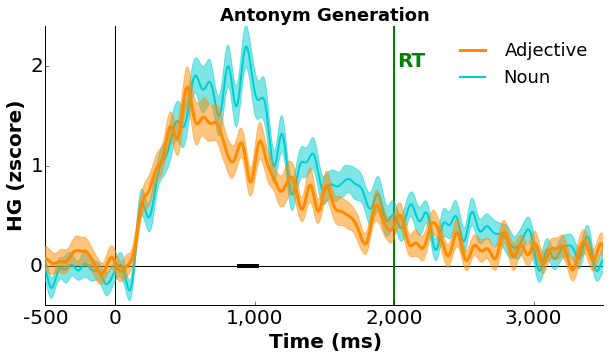

In [72]:
## PLOT FIGURES (GP15 e52 and ST32 e2)

subj, task, elec = ['GP15', 'EmoGen', 52]
#subj, task, elec = ['ST32', 'DecisionVis', 2]
#datadir = os.path.join(SJdir, 'PCA', 'compare_conditions', 'mydata')

dfstats = pd.read_csv(os.path.join(SJdir, 'PCA','compare_conditions','EmoGen', 'noFDR', 'sig_windows.csv'))
#dfstats = pd.read_csv(os.path.join(datadir,'noFDR', 'sig_windows.csv')) #my data
dftimes = dfstats[(dfstats.subj == subj)& (dfstats.elec == elec)][['start_idx','end_idx']]
start_idx = dftimes.start_idx.values
end_idx = dftimes.end_idx.values

filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv')
df = pd.read_csv(filename)
bl_st = -500

#get data
filename = os.path.join(SJdir, 'Subjs', subj, task, 'HG_elecMTX_zscore.mat')
data_dict = loadmat.loadmat(filename)
data = data_dict['data_zscore']
active_elecs = data_dict['active_elecs']
RTs = data_dict['RTs']

filename = os.path.join(SJdir,'Subjs', subj, task, 'tagged_onsets.mat')
data_dict = loadmat.loadmat(filename)
dfonsets = pd.DataFrame(data_dict['tagged_onsets'], columns = ['times','type'])
tags = dfonsets['type'].values
levels = np.unique(tags)

# filename = os.path.join(SJdir,'Subjs', subj, task, 'levels.mat')
# data_dict = loadmat.loadmat(filename)
# levels = data_dict['levels']


eidx = np.in1d(active_elecs, elec)
k = np.where(eidx)[0]

datastack_1 = data[eidx,:,:].squeeze()[((tags == levels[0])),:]
datastack_2 = data[eidx,:,:].squeeze()[((tags == levels[1])),:]
# datastack_1 = np.vstack(data[k,:,:].squeeze()[((levels == 0) | (levels == 20)),:])
# datastack_2 = np.vstack(data[k,:,:].squeeze()[((levels == 80) | (levels == 10)),:])
print(datastack_1.shape, datastack_2.shape)

#plot
f, ax = plt.subplots(figsize = (10, 5))
ax.axhline(y = 0, color = 'k', lw = 1)
ax.axvline(x = 0, color = 'k', lw = 1)    

# c1, c2, l1, l2 = ('darkcyan', 'darkmagenta', 'Dog', 'Cat')
c1, c2, l1, l2 = ('darkorange', 'darkturquoise', 'Adjective', 'Noun')

ax.plot(np.arange(-500, datastack_2.shape[1]-500), datastack_2.mean(axis = 0), color = c1, lw = 3, label = l1, zorder = 10)
sem = np.std(datastack_2, axis = 0)/np.sqrt(datastack_2.shape[0]-1)
ax.fill_between(np.arange(-500, datastack_2.shape[1]-500), datastack_2.mean(axis = 0)+sem, datastack_2.mean(axis=0)-sem, zorder = 11, edgecolor = c1, facecolor = c1, alpha = 0.5)

ax.plot(np.arange(-500, datastack_1.shape[1]-500), datastack_1.mean(axis = 0), color = c2, lw = 2, label = l2, zorder = 8)
sem = np.std(datastack_1, axis = 0)/np.sqrt(datastack_1.shape[0]-1)
ax.fill_between(np.arange(-500, datastack_1.shape[1]-500), datastack_1.mean(axis = 0)+sem, datastack_1.mean(axis=0)-sem, alpha = 0.5, zorder = 9, edgecolor = c2, facecolor = c2)

ax.axvline(x = RTs.mean(), color = 'k', lw = 2, c ='g')#, ls = ':')#, label = 'Mean RT')# - %ims' %(RTs.mean()))

if start_idx.size>0:
    for i, s in enumerate(start_idx):
        tmp = np.arange(s, end_idx[i])
        start = s
        finish = end_idx[i]
        if (finish-start) > 100:
            print (finish-start)
            ax.plot(tmp, np.zeros(tmp.size), color = 'black', linewidth = 4)#, label = (start, finish))
    #ax.plot(tmp, np.zeros(tmp.size), color = 'black', linewidth = 4, label = r"$p$" " < 0.01\n(>100 ms)")

ax.autoscale(tight = True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_xticks([-500, 0, 1000, 2000, 3000])
ax.set_yticks(np.arange(0, 3, 1))
ax.set_ylabel('HG (zscore)', fontsize = 20, weight = 'bold')
ax.set_xlabel('Time (ms)', fontsize = 20, weight = 'bold')
ax.xaxis.set_tick_params(labelsize = 20)
ax.yaxis.set_tick_params(labelsize = 20)
#ax.set_ylim([-0.25, 2.4])
ax.set_xlim([-500, 3500])
ax.set_title('Antonym Generation', fontsize = 18, fontweight = 'bold')
# ax.set_title('Visual Categorization', fontsize = 20, fontweight = 'bold')

ax.annotate('RT', xy = (RTs.mean()+30, 2), color = 'green', fontsize = 20, fontweight = 'bold')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

handles, labels = ax.get_legend_handles_labels()
lgnd = ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1,1), fontsize = 18, frameon = False)    

filename = os.path.join(SJdir, 'PCA','Figures', '%s_%s_%i_category_noFDR_commas.png' %(subj, task, elec))
f.savefig(filename, bbox_inches='tight', dpi = 150)
#plt.close()


In [448]:
dfall = pd.DataFrame([subjlist, tasklist, eleclist, starts, ends, dur, min_p, max_p])

dfall = dfall.transpose()
dfall.columns = ['subj','task','elec','start_idx','end_idx', 'dur', 'min_p', 'max_p']

dfall.to_csv(os.path.join(savedir, 'noFDR', 'sig_windows.csv'))

In [15]:
## ttest between RTs for nouns and adjectives
filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv')
df = pd.read_csv(filename)

stat_val = []

for i in df.groupby(['subj','task']):
    subj, task = i[0]

    if subj not in ['JH2','GP35','GP15']:
        continue
    if task not in ['EmoGen']:
        continue

    savedir = os.path.join(SJdir, 'PCA', 'compare_conditions', task)

    filename = os.path.join(SJdir, 'Subjs', subj, task, 'HG_elecMTX_zscore.mat')
    data_dict = loadmat.loadmat(filename)
    RTs = data_dict['RTs']

    filename = os.path.join(SJdir,'Subjs', subj, task, 'tagged_onsets.mat')
    data_dict = loadmat.loadmat(filename)
    dfonsets = pd.DataFrame(data_dict['tagged_onsets'], columns = ['times','type'])
    tags = dfonsets['type'].values

    t, p = stats.ttest_ind(RTs[tags == 1], RTs[tags == 2])
    
    stat_val.append((subj, task, t, p))

In [18]:
print pd.DataFrame(stat_val, columns = ['subj','task','t','p'])

   subj    task         t         p
0  GP15  EmoGen -1.305009  0.193957
1  GP35  EmoGen  3.242062  0.001677
2   JH2  EmoGen  1.975996  0.052683


In [211]:
#FACES
for p in ['S','R','SR','D']:
    cdata_all, subjs_all, tasks_all, offsets_all = [pd.DataFrame() for i in range(4)]

    for i in df.groupby(['subj','task']):
        subj, task = i[0]

        if subj not in ['JH2','JH6','GP35','GP15']:
            continue

        if task == 'FaceEmo':
            levels = [(1, 2), (3, 4)]
        elif task == 'FaceGen':
            levels = [(0, 1)]
        else:
            continue

        savedir = os.path.join(SJdir, 'PCA', 'compare_conditions', task)

        filename = os.path.join(SJdir, 'Subjs', subj, task, 'HG_elecMTX_zscore.mat')
        data_dict = loadmat.loadmat(filename)
        data = data_dict['data_zscore']
        active_elecs = data_dict['active_elecs']
        RTs = data_dict['RTs']

        filename = os.path.join(SJdir,'Subjs', subj, task, 'tagged_onsets.mat')
        data_dict = loadmat.loadmat(filename)
        dfonsets = pd.DataFrame(data_dict['tagged_onsets'], columns = ['times','type'])
        levels = dfonsets['type'].values

        elecs = list(i[1][i[1].pattern == p].elec)
        if len(elecs)==0: #the pattern doesn't exist
            continue

        eidx = np.in1d(active_elecs, elecs)

        for k in np.where(eidx)[0]:

            elec = active_elecs[k]


            for l in levels:
                levelA = l[0]
                levelB = l[1]

                datastack_1 = np.vstack(data[k,:,:][((levels == levelA)),:]) # | (levels == 20)),:])
                datastack_2 = np.vstack(data[k,:,:][((levels == levelB)),:])# | (levels == 80)),:])

                #calculate significance
                pvals = list()
                for j in np.arange(0, datastack_2.shape[1]):
                    (t, pval) = stats.ttest_ind(datastack_2[:,j], datastack_1[:,j])
                    pvals.append(pval)
                fdrthr = fdr_correct.fdr2(pvals, q = 0.05)
                thr = numpy.float64(0.05) #no fdr correction, just take p<0.05
                H = np.array(np.array(pvals<thr)).astype('int')

                if (thr>0):
                    #find elecs with window 
                    difference = np.diff(H, n = 1, axis = 0)
                    start_idx = np.where(difference==1)[0]+1
                    end_idx = np.where(difference == -1)[0]

                    if start_idx.size > end_idx.size: #last chunk goes until end
                        end_idx = np.append(end_idx, int(data.shape[1]-abs(bl_st)))

                    elif start_idx.size < end_idx.size:
                        start_idx = np.append(0, start_idx) #starts immediately significant

                    if (start_idx.size!=0):
                        if (start_idx[0] > end_idx[0]): #starts immediately significant
                            start_idx = np.append(0, start_idx)

                    if (start_idx.size!=0):
                        if (end_idx[-1] < start_idx[-1]):#significant until end
                            end_idx = np.append(end_idx, int(data.shape[1]-abs(bl_st)))
                    start_idx = start_idx + bl_st
                    end_idx = end_idx + bl_st
                else:
                    start_idx = np.zeros((1,))
                    end_idx = np.zeros((1,))


                #store
                dur.extend(end_idx - start_idx)
                start_idx = start_idx-bl_st
                end_idx = end_idx-bl_st
                min_p.extend([min(pvals[start_idx[i]:end_idx[i]]) for i in range(len(end_idx))])
                max_p.extend([max(pvals[start_idx[i]:end_idx[i]]) for i in range(len(end_idx))])
                eleclist.extend([elec]*len(end_idx))
                subjlist.extend([subj]*len(end_idx))
                tasklist.extend([task]*len(end_idx))
                levellist.extend(l*len(end_idx))

    #             f, ax = plt.subplots(figsize = (10, 5))
    #             ax.axhline(y = 0, color = 'k', lw = 1)
    #             ax.axvline(x = 0, color = 'k', lw = 1)    

    #             ax.plot(np.arange(-500, datastack_2.shape[1]-500), datastack_2.mean(axis = 0), color = 'green', lw = 3, label = '2\n%i trials' %(datastack_2.shape[0]), zorder = 10)
    #             sem = np.std(datastack_2, axis = 0)/np.sqrt(datastack_2.shape[0]-1)
    #             ax.fill_between(np.arange(-500, datastack_2.shape[1]-500), datastack_2.mean(axis = 0)+sem, datastack_2.mean(axis=0)-sem, zorder = 10, edgecolor = 'k', facecolor = 'green', alpha = 0.5)

    #             ax.plot(np.arange(-500, datastack_1.shape[1]-500), datastack_1.mean(axis = 0), color = 'purple', lw = 2, label = '1\n%i trials' %(datastack_1.shape[0]), zorder = 8)
    #             sem = np.std(datastack_1, axis = 0)/np.sqrt(datastack_1.shape[0]-1)
    #             ax.fill_between(np.arange(-500, datastack_1.shape[1]-500), datastack_1.mean(axis = 0)+sem, datastack_1.mean(axis=0)-sem, alpha = 0.5, zorder = 8, edgecolor = 'k', facecolor = 'purple')

    #             ax.axvline(x = RTs.mean(), color = 'g', lw = 2, ls = ':', label = 'Mean RT')# - %ims' %(RTs.mean()))

    #             if start_idx.size>0:
    #                 for i, s in enumerate(start_idx):
    #                     tmp = np.arange(s, end_idx[i])
    #                     start = s
    #                     finish = end_idx[i]
    #                     ax.plot(tmp, np.zeros(tmp.size), color = 'black', linewidth = 4)#, label = (start, finish))
    #                 ax.plot(tmp, np.zeros(tmp.size), color = 'black', linewidth = 4, label = 'p<0.05\nno FDR corrected')

    #             ax.autoscale(tight = True)
    #             ax.spines['top'].set_visible(False)
    #             ax.spines['right'].set_visible(False)
    #             ax.get_xaxis().tick_bottom()
    #             ax.get_yaxis().tick_left()
    #             ax.set_ylabel('HG (zscore)', fontsize = 14, weight = 'bold')
    #             ax.set_xlabel('Time (ms)', fontsize = 14, weight = 'bold')
    #             ax.xaxis.set_tick_params(labelsize = 14)
    #             ax.yaxis.set_tick_params(labelsize = 14)
    #             #ax.set_ylim([-0.25, 2.4])
    #             ax.set_xlim([-500, 3500])
    #             ax.set_title('%s %s %s e%i' %(subj, task, p, elec))

    #             #ax[0].annotate('RT', xy = (RTs.mean()+30, 2), color = 'green', fontsize = 14, fontweight = 'bold')

    #             handles, labels = ax.get_legend_handles_labels()
    #             lgnd = ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05,1), fontsize = 14, frameon = False)    

    #             filename = os.path.join(savedir, '%s_%s_%s_%i_2vs1.png' %(subj, task, p, elec))
    #             f.savefig(filename, bbox_inches='tight')
    #             plt.close()

ValueError: operands could not be broadcast together with shapes (3,) (2,) 

In [220]:
difference = np.diff(H, n = 1, axis = 0)
start_idx = np.where(difference==1)[0]+1
end_idx = np.where(difference == -1)[0]

if start_idx.size > end_idx.size: #last chunk goes until end
    #end_idx = np.append(end_idx, int(data.shape[1]-abs(bl_st)))
    print (start_idx, end_idx)

(array([ 244, 1896]), array([251]))


In [206]:
tmp = pd.DataFrame([subjlist, tasklist, eleclist, dur, min_p, max_p]).transpose()
tmp.columns = ['subj','task','elec', 'length','minp', 'maxp']
tmp.to_csv('/home/knight/matar/MATLAB/DATA/Avgusta/PCA/compare_conditions/pvalues_1v2.csv')

In [38]:
## SELF AUD
filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv')
df = pd.read_csv(filename)
bl_st = -500

savedir = os.path.join(SJdir, 'PCA', 'compare_conditions', '0vs1_neg_pos_nofdr')

for p in ['S','R','SR','D']:
    cdata_all, subjs_all, tasks_all, offsets_all = [pd.DataFrame() for i in range(4)]
    
    for i in df.groupby(['subj','task']):
        subj, task = i[0]
                
        if subj in ['ST27','ST32','CP7','CP9', 'ST4','ST6']:
            continue
            
        if task not in ['SelfAud','SelfVis']:
            continue

        if (subj, task) == ('JH2','SelfAud'): #missing from Avgusta's variables (also st4 and st6)
            continue
        
        filename = os.path.join(SJdir, 'Subjs', subj, task, 'HG_elecMTX_zscore.mat')
        data_dict = loadmat.loadmat(filename)
        data = data_dict['data_zscore']
        active_elecs = data_dict['active_elecs']
        RTs = data_dict['RTs']
        
        #filename = os.path.join(SJdir, 'Subjs', subj, task, 'levels.mat')
        #data_dict = loadmat.loadmat(filename)
        #levels = data_dict['levels']

        filename = os.path.join(SJdir,'Subjs', subj, task, '%s_%s_neg_pos_onsets.mat' %(subj, task))
        data_dict = loadmat.loadmat(filename)
        dfonsets = pd.DataFrame(data_dict['onsets'], columns = ['times','type'])
        dfonsets = dfonsets.sort('times')
        levels = dfonsets['type'].values
        
        elecs = list(i[1][i[1].pattern == p].elec)
        if len(elecs)==0: #the pattern doesn't exist
            continue
            
        eidx = np.in1d(active_elecs, elecs)
        
        for k in np.where(eidx)[0]:
            elec = active_elecs[k]
            
#             if (subj, task, elec) != ('GP15','SelfAud', 17):
#                 continue
            
            datastack_0 = np.vstack(data[k,:,:][((levels == 0)),:]) # | (levels == 20)),:])
            datastack_1 = np.vstack(data[k,:,:][((levels == 1)),:])# | (levels == 80)),:])

            print (subj, task, elec, p)
            print datastack_0.shape
            print datastack_1.shape

            #calculate significance
            pvals = list()
            for j in np.arange(0, datastack_0.shape[1]):
                (t, pval) = stats.ttest_ind(datastack_0[:,j], datastack_1[:,j])
                pvals.append(pval)
            #thr = fdr_correct.fdr2(pvals, q = 0.05)
            thr = numpy.float64(0.05) #no fdr correction, just take p<0.05
            H = np.array(np.array(pvals<thr)).astype('int')
    
            if (thr>0):
                #find elecs with window 
                difference = np.diff(H, n = 1, axis = 0)
                start_idx = np.where(difference==1)[0]+1
                end_idx = np.where(difference == -1)[0]

                if start_idx.size > end_idx.size: #last chunk goes until end
                    end_idx = np.append(end_idx, int(data.shape[1]-abs(bl_st)))

                elif start_idx.size < end_idx.size:
                    start_idx = np.append(0, start_idx) #starts immediately significant

                if (start_idx.size!=0):
                    if (start_idx[0] > end_idx[0]): #starts immediately significant
                        start_idx = np.append(0, start_idx)

                if (start_idx.size!=0):
                    if (end_idx[-1] < start_idx[-1]):#significant until end
                        end_idx = np.append(end_idx, int(data.shape[1]-abs(bl_st)))
                start_idx = start_idx + bl_st
                end_idx = end_idx + bl_st
            else:
                start_idx = np.zeros((1,))
                end_idx = np.zeros((1,))

            f, ax = plt.subplots(figsize = (10, 5))
            ax.axhline(y = 0, color = 'k', lw = 1)
            ax.axvline(x = 0, color = 'k', lw = 1)    

            ax.plot(np.arange(-500, datastack_0.shape[1]-500), datastack_0.mean(axis = 0), color = 'green', lw = 3, label = '0\n%i trials' %(datastack_0.shape[0]), zorder = 10)
            sem = np.std(datastack_0, axis = 0)/np.sqrt(datastack_0.shape[0]-1)
            ax.fill_between(np.arange(-500, datastack_0.shape[1]-500), datastack_0.mean(axis = 0)+sem, datastack_0.mean(axis=0)-sem, zorder = 10, edgecolor = 'k', facecolor = 'green', alpha = 0.5)

            ax.plot(np.arange(-500, datastack_1.shape[1]-500), datastack_1.mean(axis = 0), color = 'purple', lw = 2, label = '100\n%i trials' %(datastack_1.shape[0]), zorder = 8)
            sem = np.std(datastack_1, axis = 0)/np.sqrt(datastack_1.shape[0]-1)
            ax.fill_between(np.arange(-500, datastack_1.shape[1]-500), datastack_1.mean(axis = 0)+sem, datastack_1.mean(axis=0)-sem, alpha = 0.5, zorder = 8, edgecolor = 'k', facecolor = 'purple')

            ax.axvline(x = RTs.mean(), color = 'g', lw = 2, ls = ':', label = 'Mean RT')# - %ims' %(RTs.mean()))

            if start_idx.size>0:
                for i, s in enumerate(start_idx):
                    tmp = np.arange(s, end_idx[i])
                    start = s
                    finish = end_idx[i]
                    ax.plot(tmp, np.zeros(tmp.size), color = 'black', linewidth = 4)#, label = (start, finish))
                ax.plot(tmp, np.zeros(tmp.size), color = 'black', linewidth = 4, label = 'p<0.05\nno FDR corrected')

            ax.autoscale(tight = True)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.get_xaxis().tick_bottom()
            ax.get_yaxis().tick_left()
            ax.set_ylabel('HG (zscore)', fontsize = 14, weight = 'bold')
            ax.set_xlabel('Time (ms)', fontsize = 14, weight = 'bold')
            ax.xaxis.set_tick_params(labelsize = 14)
            ax.yaxis.set_tick_params(labelsize = 14)
            #ax.set_ylim([-0.25, 2.4])
            ax.set_xlim([-500, 3500])
            ax.set_title('%s %s %s e%i' %(subj, task, p, elec))

            #ax[0].annotate('RT', xy = (RTs.mean()+30, 2), color = 'green', fontsize = 14, fontweight = 'bold')

            handles, labels = ax.get_legend_handles_labels()
            lgnd = ax.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05,1), fontsize = 14, frameon = False)    
            
            filename = os.path.join(savedir, '%s_%s_%s_%i_0vs1_neg_pos.png' %(subj, task, p, elec))
            f.savefig(filename, bbox_inches='tight')
            plt.close()

('GP15', 'SelfAud', 12, 'S')
(40, 4138)
(42, 4138)
('GP15', 'SelfAud', 17, 'S')
(40, 4138)
(42, 4138)
('GP15', 'SelfAud', 19, 'S')
(40, 4138)
(42, 4138)
('GP15', 'SelfAud', 25, 'S')
(40, 4138)
(42, 4138)
('GP15', 'SelfAud', 42, 'S')
(40, 4138)
(42, 4138)
('GP15', 'SelfAud', 64, 'S')
(40, 4138)
(42, 4138)
('GP15', 'SelfAud', 68, 'S')
(40, 4138)
(42, 4138)
('JH17', 'SelfAud', 19, 'S')
(36, 3829)
(25, 3829)
('JH17', 'SelfAud', 30, 'S')
(36, 3829)
(25, 3829)
('JH17', 'SelfAud', 35, 'S')
(36, 3829)
(25, 3829)
('JH17', 'SelfAud', 36, 'S')
(36, 3829)
(25, 3829)
('JH17', 'SelfAud', 37, 'S')
(36, 3829)
(25, 3829)
('JH17', 'SelfAud', 38, 'S')
(36, 3829)
(25, 3829)
('JH17', 'SelfAud', 39, 'S')
(36, 3829)
(25, 3829)
('JH17', 'SelfAud', 40, 'S')
(36, 3829)
(25, 3829)
('JH17', 'SelfAud', 73, 'S')
(36, 3829)
(25, 3829)
('JH17', 'SelfAud', 77, 'S')
(36, 3829)
(25, 3829)
('JH17', 'SelfAud', 91, 'S')
(36, 3829)
(25, 3829)
('JH2', 'SelfVis', 2, 'S')
(26, 3661)
(24, 3661)
('JH2', 'SelfVis', 4, 'S')
(26, 3

In [221]:
filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv')
df = pd.read_csv(filename)


np.unique(df.query("task == 'EmoGen'").subj)

array(['GP15', 'GP35', 'JH2', 'ST1'], dtype=object)

 Extract mean amplitudes for each trial within significant segments for your tasks/subjects and output them in a csv (one for each elec that has a significant condition difference). Include condition designations (0/20/80/100) for each trial.

In [211]:
for i in dfall.groupby(['subj','task']):
    subj, task = i[0]

In [227]:
i[1][i[1].elec==1].start_idx.values

array([1026, 1859, 2370, 2904, 3510, 3626], dtype=object)

In [236]:
mean1[0].shape

(29,)

In [237]:
mean1, mean2 = [[] for i in range(2)]
for st, en in zip(start_idx, end_idx):
    mean1.append(datastack_1[:,st:en].mean(axis = 1)) #list of trial values for each start/end idx
    mean2.append(datastack_2[:, st:en].mean(axis = 1))

for m1, m2 in zip(mean1, mean2):
    print stats.ttest_ind(m1, m2)

Ttest_indResult(statistic=0.59461110873563994, pvalue=0.55430264811077701)
Ttest_indResult(statistic=0.99546908272218126, pvalue=0.3234407148887436)
Ttest_indResult(statistic=1.5484213603956392, pvalue=0.12669382201561902)
Ttest_indResult(statistic=-0.9577071770875778, pvalue=0.34199091730357833)
Ttest_indResult(statistic=0.3459853684003692, pvalue=0.73054419028762951)
Ttest_indResult(statistic=0.57245290525354264, pvalue=0.56911913078167542)
Ttest_indResult(statistic=1.7330628544753583, pvalue=0.088137384372733288)
Ttest_indResult(statistic=-1.3077115902492331, pvalue=0.19587832300162994)
Ttest_indResult(statistic=0.1551323079229785, pvalue=0.8772292020356095)
Ttest_indResult(statistic=0.99731791618787924, pvalue=0.32255007098097077)
Ttest_indResult(statistic=1.22154649146729, pvalue=0.22657914913014887)
Ttest_indResult(statistic=-0.24565760562530228, pvalue=0.80677195334983998)
Ttest_indResult(statistic=0.95733377829656996, pvalue=0.34217776362909202)
Ttest_indResult(statistic=-1.412

In [ ]:
dfall = pd.read_csv((os.path.join(savedir, 'noFDR', 'sig_windows.csv')))

for i in dfall.groupby(['subj','task']):
    subj, task = i[0]
    savedir = os.path.join(SJdir, 'PCA', 'compare_conditions', 'mydata', 'singletrials')
    
    filename = os.path.join(SJdir, 'Subjs', subj, task, 'HG_elecMTX_zscore.mat')
    data_dict = loadmat.loadmat(filename)
    data = data_dict['data_zscore']
    active_elecs = data_dict['active_elecs']
    RTs = data_dict['RTs']

    filename = os.path.join(SJdir,'Subjs', subj, task, 'tagged_onsets.mat')
    data_dict = loadmat.loadmat(filename)
    dfonsets = pd.DataFrame(data_dict['tagged_onsets'], columns = ['times','type'])
    tags = dfonsets['type'].values
    levels = np.unique(tags)

    elecs = np.unique([i[1]].elec) #elecs
    eidx = np.in1d(active_elecs, elecs)

    for k in np.where(eidx)[0]:

        elec = active_elecs[k]
        datastack_1 = np.vstack(data[k,:,:][((tags == levels[0])),:]) #trials x time
        datastack_2 = np.vstack(data[k,:,:][((tags == levels[1])),:])

        start_idx = i[1][i[1].elec==1].start_idx.values
        end_idx = i[1][i[1].elec==1].end_idx.values
        
        #calculate mean values
        mean1, mean2 = [[] for i in range(2)]
        for st, en in zip(start_idx, end_idx):
            mean1.extend(datastack_1[:,st:en].mean(axis = 1))
            mean2.extend(datastack_2[:, st:en].mean(axis = 1))
            
        
        
        #store
            eleclist.extend([elec]*len(end_idx))
            subjlist.extend([subj]*len(end_idx))
            tasklist.extend([task]*len(end_idx))            
            starts.extend(start_idx)
            ends.extend(end_idx)
            dur.extend(end_idx - start_idx)
            
            start_idx = start_idx-bl_st #shift to access data
            end_idx = end_idx-bl_st
            min_p.extend([min(pvals[start_idx[i]:end_idx[i]]) for i in range(len(end_idx))])
            max_p.extend([max(pvals[start_idx[i]:end_idx[i]]) for i in range(len(end_idx))])
    

#calculate mean values per trial
   

In [172]:
df = pd.read_csv(os.path.join(SJdir, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv'))

starts, ends, eleclist, subjlist, tasklist, min_p, max_p, dur = [[] for i in range(8)]

for i in df.groupby(['subj','task']):
    subj, task = i[0]

    if subj not in ['CP9','CP7','ST27', 'ST32']:
        continue

    savedir = os.path.join(SJdir, 'PCA', 'compare_conditions', 'mydata')

    filename = os.path.join(SJdir,'Subjs', subj, task, 'levels.mat')
    data_dict = loadmat.loadmat(filename)
    levels = data_dict['levels']

    datadir = os.path.join(SJdir, 'PCA', 'ShadePlots_hclust', 'elecs', 'significance_windows', 'unsmoothed', 'csv_files')
    dfmean = pd.read_csv(os.path.join(datadir, '%s_%s_means.csv' %(subj, task)))

    tmp = pd.DataFrame()
    dfmean = dfmean.set_index(levels)
    filename = os.path.join(savedir, '%s_%s_mean_vals.csv' %(subj, task))
    dfmean.to_csv(filename)

    #run ttest
    for e in dfmean.columns:
        tmp = tmp.append(pd.DataFrame([tuple(stats.ttest_ind(dfmean.loc[[0,20]][e], dfmean.loc[[10,80]][e]))], columns = ['t','p']))

    tmp.index = dfmean.columns
    filename = os.path.join(savedir, '%s_%s_ttest_stats.csv' %(subj, task))
    tmp.to_csv(filename)        


('CP7', 'DecisionAud', ['14', '23', '28', '53', '76'])
('CP9', 'DecisionAud', ['11', '23', '28', '41'])
('ST27', 'DecisionVis', ['15', '33', '41', '102'])
('ST32', 'DecisionVis', ['1', '3', '100', '101'])


In [178]:
#find elecs that have step function and are duration
tmpall = pd.DataFrame()
for i in df.groupby(['subj','task']):
    subj, task = i[0]

    if subj not in ['CP9','CP7','ST27', 'ST32']:
        continue

    filename = os.path.join(savedir, '%s_%s_ttest_stats.csv' %(subj, task))
    tmp = pd.read_csv(filename)
    tmp.columns = ['elec','t','p']
    tmp['subj'] = subj
    tmp['task'] = task
    tmp = pd.merge(df[['subj','task','elec','pattern']],tmp)
    
    tmpall = tmpall.append(tmp)

In [181]:
filename = os.path.join(savedir, 'ttest_stats.csv')
tmpall.to_csv(filename)

In [183]:
tmpall.query("p<0.05").groupby('pattern').count()

,subj,task,elec,t,p
pattern,,,,,
D,5,5,5,5,5
R,3,3,3,3,3
S,3,3,3,3,3
SR,6,6,6,6,6


In [157]:
#find significant windows that <100ms and p<0.01
tmp = pd.read_csv(os.path.join(SJdir, 'PCA', 'compare_conditions','EmoGen', 'noFDR', 'sig_windows.csv'))
cols = list(tmp.columns)
cols.remove('Unnamed: 0')
tmp = tmp[cols]

filename = os.path.join(SJdir, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv')
df = pd.read_csv(filename)

In [159]:
tmp = pd.merge(df[['subj','task','elec','pattern']],tmp)

In [166]:
tmp.query("dur>100 and min_p<0.01").groupby(['subj','elec', 'pattern']).mean()

start_idx  end_idx    dur     min_p     max_p
subj elec pattern                                               
GP15 10   D             1607   1710.0  103.0  0.002638  0.049532
     52   D              887   1015.0  128.0  0.000002  0.049526
GP35 4    D              929   1056.0  127.0  0.003204  0.047955
     5    D             1980   2093.5  113.5  0.000429  0.046165
     7    D             2157   2343.0  186.0  0.005384  0.047597
     22   SR            1118   1238.0  120.0  0.001743  0.048357
     45   D             1284   1393.0  109.0  0.003419  0.048726
JH2  2    D             3712   3826.0  114.0  0.005425  0.047531
     13   D              149    259.0  110.0  0.005498  0.049147

In [438]:

## stimuli lengths
filename = os.path.join(SJdir, 'Subjs', 'GP15', 'SelfAud', 'HG_elecMTX_zscore.mat')
data_dict = loadmat.loadmat(filename)
data = data_dict['data_zscore']
active_elecs = data_dict['active_elecs']
RTs = data_dict['RTs']
offsets = data_dict['offsets_stim'] - data_dict['onsets_stim'] #stim offsets relative to onset (durations)


In [439]:
print (min(offsets), max(offsets))
print (mean(offsets), std(offsets))

(305, 1024)
(687.01219512195121, 120.29896639079506)


In [427]:
print (min(offsets), max(offsets))
print (mean(offsets), std(offsets))

(295, 1013)
(638.93197278911566, 114.27426489457956)


In [428]:
pattern = ['S','SR','R','D']
for p in ['D']:
    filename= os.path.join(SJdir, 'SingleTrials','alltrials','data', 'singletrials_allelecs_smooth_' + p + '_dropSR.mat')
    data_dict = loadmat.loadmat(filename)